# Block-Silhouette Analysis for CogSci 2020

## Import and set up directories

In [321]:
import os
import sys
import urllib, io
os.getcwd()
sys.path.append("..")
proj_dir = os.path.abspath('../..')

if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))

import numpy as np
import scipy.stats as stats
import pandas as pd
from random import random

import pymongo as pm
from collections import Counter
import json
import re
import ast

from PIL import Image, ImageOps, ImageDraw, ImageFont 

from io import BytesIO
import base64

import  matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

import seaborn as sns
sns.set_context('talk')
sns.set_style('darkgrid')

from IPython.display import clear_output

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

import blockworld_helpers as utils
import drawing_utils as drawing
import importlib

In [322]:
## directory & file hierarchy
proj_dir = os.path.abspath('..')
datavol_dir = os.path.join(proj_dir,'data')
analysis_dir = os.path.abspath(os.path.join(os.getcwd(),'..'))
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
json_dir = os.path.join(results_dir,'json')
exp_dir = os.path.abspath(os.path.join(proj_dir,'experiments'))
png_dir = os.path.abspath(os.path.join(datavol_dir,'png'))
jefan_dir = os.path.join(analysis_dir,'jefan')
will_dir = os.path.join(analysis_dir,'will')

## add helpers to python path
if os.path.join(proj_dir,'stimuli') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'stimuli'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       

## Load Data

In [323]:
iteration_name = 'Exp2Pilot3'
num_trials = 24 #for sanity checks

In [331]:
# Data already compiled into dataframes in CogSci 2020 Dataframe Generator

# trial_end data
trial_path = os.path.join(csv_dir,'block_silhouette_{}.csv'.format(iteration_name))
df = pd.read_csv(trial_path)

# # initial_block data
initial_path = os.path.join(csv_dir,'block_silhouette_initial_{}.csv'.format(iteration_name))
dfi = pd.read_csv(initial_path)

# # settled_block data
settled_path = os.path.join(csv_dir,'block_silhouette_settled_{}.csv'.format(iteration_name))
dfs = pd.read_csv(settled_path)

# # Sanity Check- same participants in each dataset.
df_participants = df.gameID.unique()
dfs_participants = dfs.gameID.unique()
assert Counter(df_participants) == Counter(dfs_participants)

n_before_outliers = len(df_participants)
print(str(n_before_outliers) + ' participants total')

49 participants total


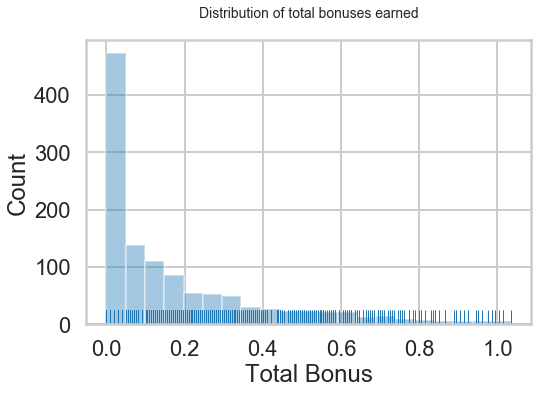

In [325]:
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
c = sns.distplot(df['score'],
                rug=True,
                kde=False)
plt.ylabel('Count')
plt.xlabel('Total Bonus')
plt.title('Distribution of total bonuses earned\n',{'fontsize': 14})
plt.tight_layout()

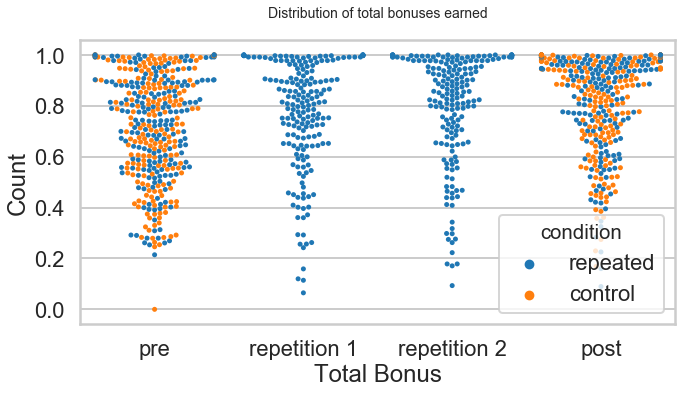

In [326]:
fig = plt.figure(figsize=(10,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
c = sns.swarmplot(x = 'phase_extended',
                  y = 'normedScoreDiscrete',
                  hue = 'condition',
            data = df)
plt.ylabel('Count')
plt.xlabel('Total Bonus')
#plt.xticks(np.arange(df.gameID.nunique()),[str(n) for n in np.arange(df.gameID.nunique())])
plt.title('Distribution of total bonuses earned\n',{'fontsize': 14})
plt.tight_layout()


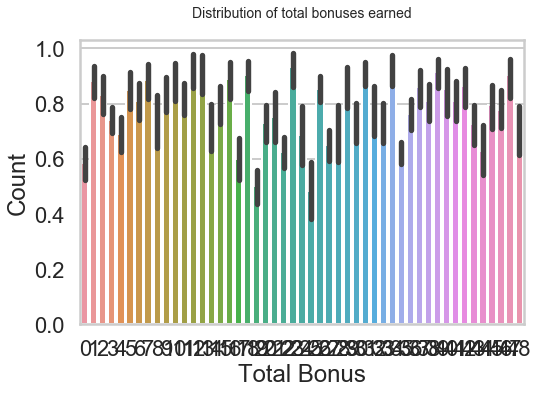

In [327]:
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
c = sns.barplot(x = 'gameID',
                y = 'normedScoreDiscrete',
                #hue = 'phase',
                #hue = 'repetition',
                data = df)
plt.ylabel('Count')
plt.xlabel('Total Bonus')
plt.xticks(np.arange(df.gameID.nunique()),[str(n) for n in np.arange(df.gameID.nunique())])
plt.title('Distribution of total bonuses earned\n',{'fontsize': 14})
plt.tight_layout()

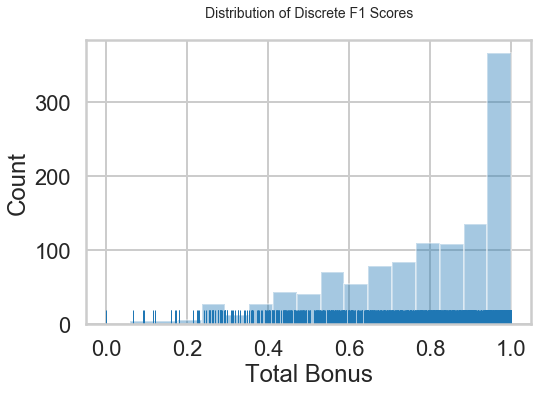

In [328]:
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
c = sns.distplot(df['normedScoreDiscrete'],
                rug=True,
                kde=False)
plt.ylabel('Count')
plt.xlabel('Total Bonus')
plt.title('Distribution of Discrete F1 Scores\n',{'fontsize': 14})
plt.tight_layout()


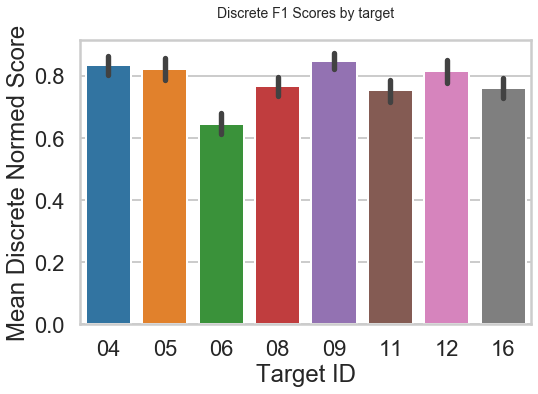

In [329]:
names = df.targetName.unique()
names.sort()
structure_numbers = list(map(lambda x: x[-2:],names))

fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
c = sns.barplot(x = 'targetName',
                y = 'normedScoreDiscrete',
                order = names,
                data = df)
plt.ylabel('Mean Discrete Normed Score')
plt.xlabel('Target ID')
plt.xticks(np.arange(len(names)),structure_numbers)
plt.title('Discrete F1 Scores by target\n',{'fontsize': 14})
plt.tight_layout()

In [330]:
# exclude outliers with low mean normed score
remove_outliers = False

if remove_outliers:

    threshold = 0.7

    df_means = df.groupby(by=['gameID'])['normedScoreDiscrete'].apply(np.mean).reset_index()
    low_scores = df_means[df_means.normedScoreDiscrete< threshold]['gameID'] 
    print(low_scores)
    df = df[~df.gameID.isin(low_scores)]
    dfi = dfi[~dfi.gameID.isin(low_scores)]
    dfs = dfs[~dfs.gameID.isin(low_scores)]

    n = df.gameID.nunique()
    print(str(n) + ' participants with score <'+str(threshold)+' and full set of trials')



0     0145-8cab6010-6b88-4e57-b04d-b9e9b4b7c959
4     0652-88ebf36e-0780-4434-a9c7-969af27c2636
17    3434-b4d883f9-3dff-48d4-88c0-ee40d88066c9
19    3988-e15c8e2e-0b53-43fd-a2d3-686d3efd6923
22    4452-eae81be5-9537-4c6e-900f-5243f6eebe7e
24    4611-415301bd-3cd2-4751-9911-e530d1bce758
25    4739-25f27c31-0d4c-46ae-a515-02351c69042d
27    4889-4e19ed70-4376-476c-857e-028e0af87a64
28    5297-31ebba85-e71d-4a00-9a58-7e31948237a0
35    8393-20a088d6-1640-4144-9c9b-1a4de630af05
44    9415-40177ff4-0b4d-494c-96b4-3409ff007cdb
Name: gameID, dtype: object
38 participants with score <0.7 and full set of trials


In [272]:
# Exclude outliers with low total bonus

remove_outliers = False

if remove_outliers:

    low_scores = df[(df.trialNum == (num_trials-1)) & (df.score == 0)]['gameID'] # people who achieved zero bonus


    df = df[~df.gameID.isin(low_scores)]
    dfi = dfi[~dfi.gameID.isin(low_scores)]
    dfs = dfs[~dfs.gameID.isin(low_scores)]

    n = df.gameID.nunique()
    print(str(n) + ' participants with score > 0 and full set of trials')


18 participants with score > 0 and full set of trials


In [ ]:
importlib.reload(drawing)
drawing.draw_all_trials(df, figsize=(20,80))

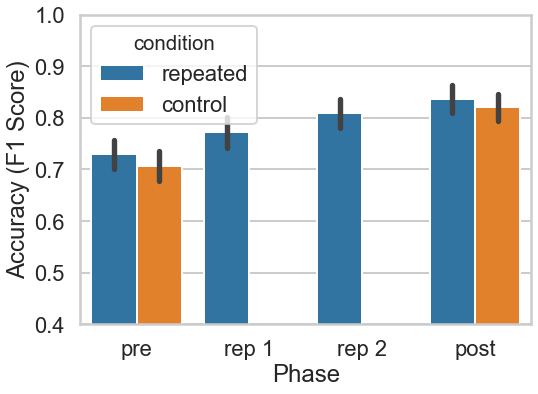

In [332]:
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
c = sns.barplot(x='phase_extended', 
                y='normedScoreDiscrete', 
                hue='condition', 
                #kind='point', 
                #legend=False,
                data=df);
plt.ylabel('Accuracy (F1 Score)')
plt.xlabel('Phase')
plt.ylim(0.4,1)
plt.xticks(np.arange(4),['pre','rep 1', 'rep 2', 'post'])
plt.tight_layout()


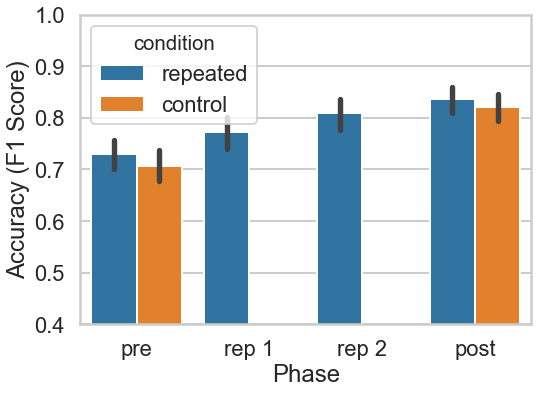

In [333]:
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
c = sns.barplot(x='phase_extended', 
                y='normedScoreDiscrete', 
                hue='condition', 
                #kind='point', 
                #legend=False,
                data=df);
plt.ylabel('Accuracy (F1 Score)')
plt.xlabel('Phase')
plt.ylim(0.4,1)
plt.xticks(np.arange(4),['pre','rep 1', 'rep 2', 'post'])
plt.tight_layout()

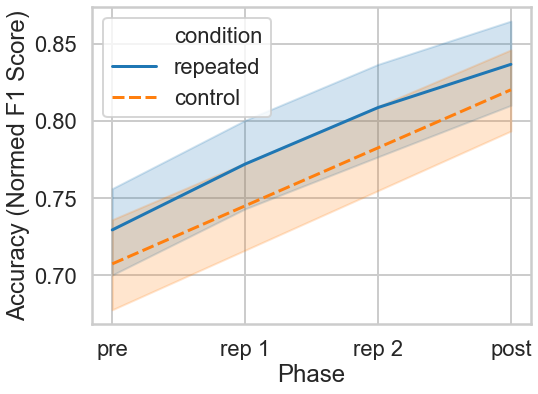

In [334]:
# Accuracy by phase
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
c = sns.lineplot(x='phase_number', 
                y='normedScoreDiscrete', 
                hue='condition',
                style='condition',
                style_order=['repeated','control'],
                #kind='point', 
                #legend=False,
                data=df);
plt.ylabel('Accuracy (Normed F1 Score)')
plt.xlabel('Phase')
plt.xticks(np.arange(4),['pre','rep 1', 'rep 2', 'post'])
#plt.yticks(np.linspace(0.4,1,5))
plt.tight_layout()

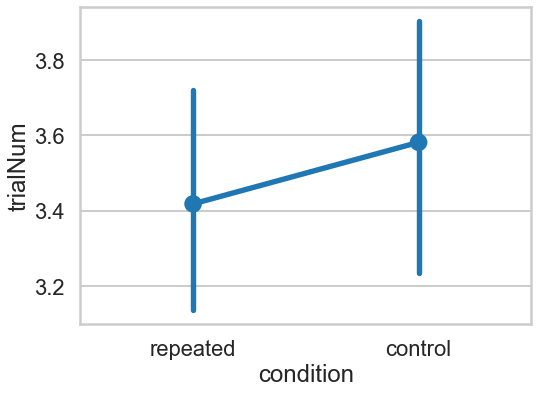

In [345]:
#double check that repeated condition isn't coming after control

fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
c = sns.pointplot(x='condition', 
                y='trialNum', 
                #hue='condition',
                #kind='point', 
                #legend=False,
                data=df[df.phase=='pre']);

#plt.yticks(np.linspace(0.4,1,5))
plt.tight_layout()

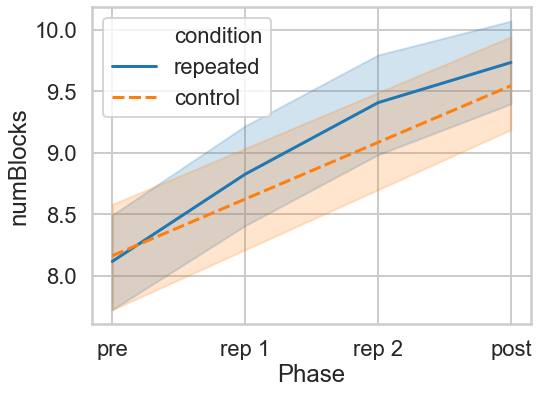

In [346]:
# Number of blocks placed by phase
# Should we control for fallen structures? 

df.groupby(by='phase_extended').apply(np.mean)


fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
c = sns.lineplot(x='phase_number', 
                y='numBlocks', 
                hue='condition',
                style='condition',
                style_order=['repeated','control'],
                #kind='point', 
                #legend=False,
                data=df);
plt.ylabel('numBlocks')
plt.xlabel('Phase')
plt.xticks(np.arange(4),['pre','rep 1', 'rep 2', 'post'])
#plt.yticks(np.linspace(0.4,1,5))
plt.tight_layout()

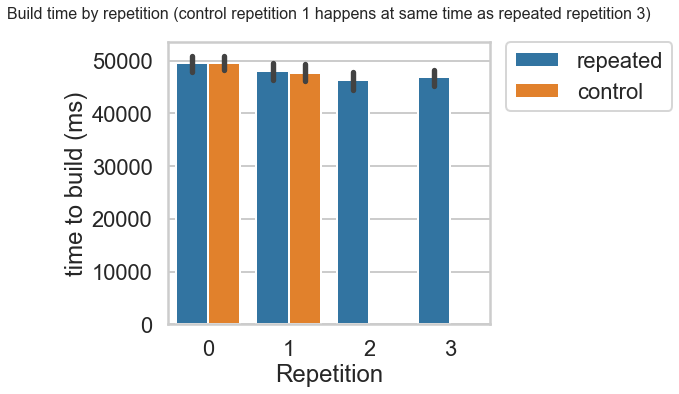

In [347]:
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
c = sns.barplot(x='repetition', 
                y='timeToBuild', 
                hue='condition', 
                #kind='point', 
                #legend=False,
                data=df)
plt.ylabel('time to build (ms)')
plt.xlabel('Repetition')
plt.title('Build time by repetition (control repetition 1 happens at same time as repeated repetition 3)\n',{'fontsize': 16})
#plt.ylim(0.4,1)
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

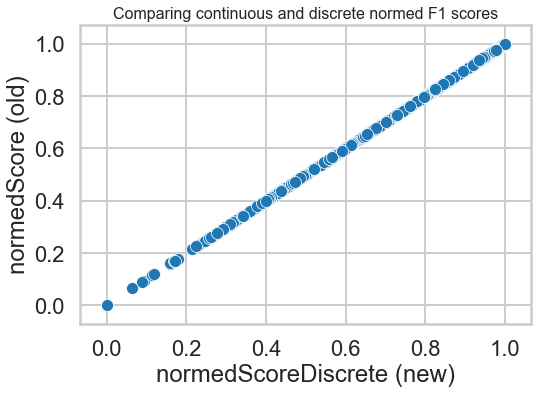

In [348]:
fig = plt.figure(figsize=(8,6))
sns.set_context('poster')
sns.set_style('whitegrid', {'legend.frameon':False})
c = sns.scatterplot(x='normedScoreDiscrete', 
                y='normedScore', 
                #hue='condition', 
                #kind='point', 
                #legend=False,
                data=df)
plt.ylabel('normedScore (old)')
plt.xlabel('normedScoreDiscrete (new)')
plt.title('Comparing continuous and discrete normed F1 scores',{'fontsize': 16})
#plt.ylim(0.4,1)
plt.tight_layout()
